Left off at DBScan

# TOC

0. [Imports](#first-bullet)
1. [EDA](#1.0-bullet)
2. [Feature Engineering](#2.0-bullet)  
 2.1 [Pt 1 - Regression](#2.1-bullet)  
 2.2 [Pt 2 - Classification](#2.2-bullet)
3. [Basic Model](#3.0-bullet)  
 3.1 [Pt 1 - Regression](#3.1-bullet)  
 3.2 [Pt 2 - Classification](#3.2-bullet)
4. [Reference and Planning](#4.0-bullet)

In [10]:
#Basic
import pandas as pd
import numpy as np
#Math
import scipy as sp
from random import randint
from math import exp
import operator

#Scraping
import requests
import json

#Youtube Data API Packages: 
"""from apiclient.discovery import build
from apiclient.errors import HttpError
from oauth2client.tools import argparser
from googleapiclient.discovery import build
import argparse
from googleapiclient.errors import HttpError"""

#Modeling
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
#from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import r2_score,confusion_matrix, roc_auc_score, roc_curve

#NLP & Text Management
# from sklearn.feature_extraction import stop_words
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer
# import re
# from textblob import TextBlob
# from wordcloud import WordCloud
# from nltk.stem import PorterStemmer

#Time analysis
import time
import datetime
# from statsmodels.tsa.stattools import pacf
# from statsmodels.graphics.tsaplots import plot_pacf

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
#from wordcloud import WordCloud

%matplotlib inline
plt.style.use('classic')
sns.set_style('whitegrid')

In [78]:
df_main = pd.read_csv('./data/engineered_data/data_genres.csv')

In [79]:
model_time = ['is_weekend', 'is_friday', 'year_day', 'week', 'week_day', 'month', 'month_day', 'year',  ]
model_text = ['description_sentiment', 'description_wordcount',
  'tags_sentiment', 'tags_wordcount', 'title_sentiment',
 'title_wordcount', 'title_featuring', 'title_length', ]
model_title_letter = ['intitle_a',  'intitle_b', 'intitle_c', 'intitle_d', 'intitle_e', 'intitle_f', 'intitle_g',
 'intitle_h', 'intitle_i', 'intitle_j', 'intitle_k', 'intitle_l', 'intitle_m', 'intitle_n', 'intitle_o',
 'intitle_p', 'intitle_q', 'intitle_r', 'intitle_s', 'intitle_t', 'intitle_u', 'intitle_v', 'intitle_w',
 'intitle_x', 'intitle_y', 'intitle_z',]              
model_ratios = ['lv_ratio', 'comment_view_ratio', 'like_dislike_ratio',]
model_other = ['duration', 'contentRating', 'regionRestriction',  'licensedContent', 'caption', 'definition']
measures = ['likeCount', 'dislikeCount', 'commentCount', 'viewCount',
            'view_log',  'comment_log',  'like_log', 'dislike_log', 
            'view_class' ]
non_model_cols = ['request_token', 'letter_search','channelTitle', 'tags', 'title', 'vidId','publishedAt','favoriteCount',
              'description','defaultLanguage', ]

In [80]:
genre_list_str = ['alt_words', 'blues_words', 'christian_words', 'classical_words', 'country_words', 'dubstep_words', 
                 'edm_words', 'extended_words', 'folk_words', 'halloween_words', 'hit_words', 'italian_words', 'jazz_words', 
                 'kpop_words', 'latin_words', 'love_songs', 'other_rock_words', 'pop_words', 'rap_words', 'remix_words', 
                 'reggae_words', 'romanian_words', 'relax_words', 'rock_words', 'trap_words']
deltas_list = ['like_baseline_delta', 'comment_baseline_delta', 'dislike_baseline_delta', 'ld_baseline_delta' ]

In [81]:
baseline_stats = pd.read_csv('./data/engineered_data/engagement_matrix.csv')

In [82]:
df_formodel = df_main[(df_main.view_log>4)&(df_main.lv_ratio>0)&(df_main.comment_view_ratio>0)&(df_main.like_dislike_ratio<10)]

In [83]:
df_formodel.columns

Index(['index', 'caption', 'channelTitle', 'commentCount', 'defaultLanguage',
       'definition', 'description', 'dislikeCount', 'duration',
       'favoriteCount', 'licensedContent', 'likeCount', 'publishedAt',
       'regionRestriction', 'tags', 'title', 'vidId', 'viewCount',
       'request_token', 'letter_search', 'contentRating', 'year', 'month',
       'month_day', 'year_day', 'week_day', 'view_log', 'comment_log',
       'like_log', 'dislike_log', 'view_class', 'week',
       'description_sentiment', 'description_wordcount', 'tags_sentiment',
       'tags_wordcount', 'title_sentiment', 'title_wordcount',
       'title_featuring', 'title_length', 'lv_ratio', 'comment_view_ratio',
       'like_dislike_ratio', 'is_weekend', 'is_friday', 'alt_words',
       'blues_words', 'christian_words', 'classical_words', 'country_words',
       'dubstep_words', 'edm_words', 'extended_words', 'folk_words',
       'halloween_words', 'hit_words', 'italian_words', 'jazz_words',
       'kpop_words'

# <a class="anchor" id="1.0-bullet">1. Basic Grouping</a>

Do this first, then go back and do it without converting to logs, if meaningful

In [84]:
#Engagement per second of content? See diminishing returns

In [85]:
like_dict ={}
comment_dict = {}
dislike_dict = {}
ld_dict = {}
view_dict = {}
duration_dict = {}
for genre in genre_list_str:
    like_dict[genre.replace('_words', '')] = df_formodel[df_formodel[genre]==1].like_baseline_delta.mean()
    comment_dict[genre.replace('_words', '')] = df_formodel[df_formodel[genre]==1].comment_baseline_delta.mean()
    dislike_dict[genre.replace('_words', '')] = df_formodel[df_formodel[genre]==1].dislike_baseline_delta.mean()
    ld_dict[genre.replace('_words', '')] = df_formodel[df_formodel[genre]==1].ld_baseline_delta.mean()
    view_dict[genre.replace('_words', '')] = df_formodel[df_formodel[genre]==1].view_log.mean()
    duration_dict[genre.replace('_words', '')] = df_formodel[df_formodel[genre]==1].duration.mean()

In [86]:
df_engagement = pd.concat([
    pd.Series(like_dict), pd.Series(comment_dict), pd.Series(dislike_dict), pd.Series(ld_dict), pd.Series(view_dict), pd.Series(duration_dict)]
    , axis=1)

In [87]:
df_engagement.columns=['likes', 'comments', 'dislikes', 'likes_dislikes', 'views', 'duration']

In [126]:
df_engagement.sort_values(by='likes_dislikes', ascending=True)

,likes,comments,dislikes,likes_dislikes,views,duration
reggae,0.490448,0.684599,0.651843,-17.344890,6.605652,252.666667
kpop,-0.730521,-0.773558,0.010457,-2.282547,6.724559,459.317073
classical,0.643343,0.286811,0.743747,-1.418765,5.754542,1333.038462
hit,0.126122,0.076246,0.254928,-1.232357,7.662304,259.024444
country,0.378359,0.534521,0.146548,-1.105841,6.806138,328.500000
pop,-0.048443,-0.038062,0.062902,-0.748030,7.237326,303.896119
remix,0.005447,0.073798,0.111826,-0.378337,7.210568,328.937388
extended,0.049315,0.083529,0.103864,-0.360345,6.312149,634.700000
rock,0.117103,0.029970,0.220484,-0.333633,6.824143,429.356643
love_songs,-0.416011,-0.296158,0.074779,-0.315138,6.933464,383.291667


In [93]:
df_main[df_main.title.str.contains('White Noise')].kpop_words

1873    False
Name: kpop_words, dtype: bool

# <a class="anchor" id="1.0-bullet">1. Functions</a>

In [94]:
df_forclass = df_formodel.loc[:, genre_list_str + deltas_list] #

In [96]:
from sklearn.cluster import DBSCAN, KMeans

In [97]:
from sklearn.metrics import silhouette_score

In [98]:
ss = StandardScaler()
df_forclass_sc = ss.fit_transform(df_forclass)

In [105]:
len(genre_list_str)

25

In [111]:
n_dict = {}
for n in range(3, 40): 
    k_classifier = KMeans(n_clusters=n, random_state=42)
    n_dict[n] = silhouette_score(df_forclass_sc, k_classifier.fit_predict(df_forclass_sc)) 
    print('   n: ', n, ' silhouette: ', n_dict[n], ' intertia: ' , k_classifier.inertia_)

   n:  3  silhouette:  0.15191665548548355  intertia:  193082.6000805104
   n:  4  silhouette:  0.1538129229426103  intertia:  185478.83871179383
   n:  5  silhouette:  0.16976675456434234  intertia:  178205.84122492417
   n:  6  silhouette:  0.17347619645963608  intertia:  170711.49895128288
   n:  7  silhouette:  0.15759742756257786  intertia:  164080.09245525522
   n:  8  silhouette:  0.17211814708717058  intertia:  156493.94550984298
   n:  9  silhouette:  0.1838505935414592  intertia:  148573.8279753702
   n:  10  silhouette:  0.20106931888420024  intertia:  141021.47971465046
   n:  11  silhouette:  0.22118331979590317  intertia:  134618.2282813151
   n:  12  silhouette:  0.21080165490293912  intertia:  126142.67610615239
   n:  13  silhouette:  0.19639410872453272  intertia:  119564.83665811589
   n:  14  silhouette:  0.20969337977218028  intertia:  111884.3105329487
   n:  15  silhouette:  0.21110057508597668  intertia:  105289.34482915894
   n:  16  silhouette:  0.208683420646

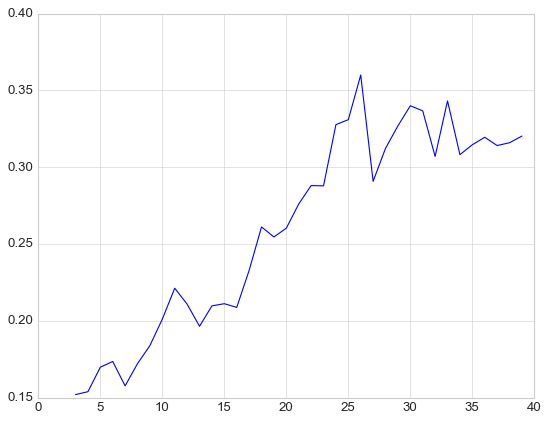

In [113]:
fig, ax = plt.subplots()
ax.plot(n_dict.keys(), n_dict.values())

In [103]:
#['tags_sentiment', 'description_sentiment', 'description_wordcount', 'title_featuring', 'duration', 'year', 'title_length', 'lv_ratio', 'view_log']

In [114]:
k_classifier = KMeans(n_clusters=25, random_state=42)
k_classifier.fit(df_forclass_sc)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=25, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [115]:
df_formodel['k_class'] = k_classifier.predict(df_forclass_sc)

In [124]:
df_formodel.loc[:, genre_list_str+['k_class', 'lv_ratio']].groupby('k_class').sum().T.to_csv('./data/classifieds/genre_classes.csv')

### DBScan

In [122]:
db_model = DBSCAN()

pd.DataFrame(db_model.fit_predict(df_forclass_sc), columns=['class'])['class'].value_counts()

 0     4340
-1     1647
 5      386
 4      184
 3      147
 6      109
 16      61
 9       52
 1       52
 8       47
 19      40
 2       37
 11      31
 12      27
 20      18
 14      13
 22      12
 15      12
 30       9
 10       9
 21       9
 17       8
 24       8
 18       7
 32       7
 23       7
 29       6
 33       6
 13       6
 26       6
 27       6
 28       5
 39       5
 36       5
 40       5
 25       5
 35       5
 34       5
 38       5
 7        5
 31       5
 37       5
Name: class, dtype: int64

In [138]:
db_preds = db_model.fit_predict(uns_X_sc)
df_db_classes = df_main[df_main.view_class>1]

In [139]:
df_db_classes['db_class'] = db_preds

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
